In [1]:
import os

current_path = os.getcwd()
print(current_path)


/fast/AG_Metzger/daniela/python


In [2]:
import torch

In [3]:
torch.cuda.is_available()

True

In [4]:
from fastai.vision.all import *
from sklearn.metrics import f1_score
import numpy as np
from fastcore import *

In [6]:
disease_path = Path('/fast/AG_Metzger/jakob/a728b741-9fed-4bfc-906f-5b828b882892/images/RGB_disease_desmin_disease/')
wild_type_path = Path('/fast/AG_Metzger/jakob/a728b741-9fed-4bfc-906f-5b828b882892/images/RGB_wt_desmin_wild_type/')

def get_label(o):
    if o.parent.name == 'RGB_disease_desmin_disease':
        return 'disease'
    elif o.parent.name == 'RRGB_wt_desmin_wild_type':
        return 'wild_type'
    else:
        raise ValueError(f"Unknown label for {o}")

In [7]:
def get_label(o):
    if o.parent.name == 'RGB_disease_desmin_disease':
        return 'disease'
    elif o.parent.name == 'RGB_wt_desmin_wild_type':
        return 'wild_type'
    else:
        return 'unknown'  


In [23]:
disease_files = get_image_files(disease_path)
wild_type_files = get_image_files(wild_type_path)

num_samples = min(len(disease_files), len(wild_type_files))
disease_files = disease_files[:num_samples]
wild_type_files = wild_type_files[:num_samples]

files = disease_files + wild_type_files
labels = {**{f:disease_path.name for f in disease_files}, **{f:wild_type_path.name for f in wild_type_files}}

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda x: files,
    splitter=RandomSplitter(valid_pct=0.3, seed=123),
    get_y=get_label,
    item_tfms=[Resize(224)],
    batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)]
)
dls = dblock.dataloaders(source=(disease_path, wild_type_path), bs=18, num_workers=4)

num_val_samples = len(dls.valid_ds)
if num_val_samples == 0:
    raise ValueError("Validation set is empty.")


learn = cnn_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(10, cbs=[EarlyStoppingCallback(patience=2)])
print(f'The accuracy of the model is {learn.recorder.values[-1][-1]:.2%}.')


val_indices = range_of(dls.valid)
val_files = [files[i] for i in val_indices]
val_preds = learn.get_preds(dl=dls.valid)
mean_preds = val_preds[0].mean()
std_preds = val_preds[0].std()

learn.export('model_tuned_desminsmntubb3.pkl')

/home/mhernan/miniconda3/envs/gpuenv/lib/python3.9/site-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/home/mhernan/miniconda3/envs/gpuenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mhernan/miniconda3/envs/gpuenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The accuracy of the model is 98.91%.


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

Results saved at: /fast/AG_Metzger/daniela/python/python_folder/results_desmin.csv


/tmp/7153087.1.gpu.q/ipykernel_97384/899515400.py:20: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=df_valid, x='class', y='prediction', ax=ax, jitter=0.1, palette=['green', 'red'], alpha=0.5)


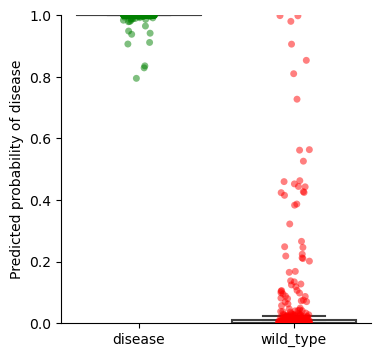

Image saved at: /fast/AG_Metzger/daniela/python/python_folder/desmin_probs


<Figure size 640x480 with 0 Axes>

In [24]:
val_preds, val_targs = learn.get_preds(dl=dls.valid)
df_valid = pd.DataFrame({'class': [dls.vocab[i] for i in val_targs], 'prediction': val_preds[:, 0]})
df_valid.to_csv('/fast/AG_Metzger/daniela/python/python_folder/results_train_desmin', index=False)


print("Results saved at: /fast/AG_Metzger/daniela/python/python_folder/results_desmin.csv")


fig, ax = plt.subplots(figsize=(4, 4))
#sns.stripplot(data=df_valid, x='class', y='prediction', ax=ax, jitter=0.1, color='gray', alpha=0.5)
sns.stripplot(data=df_valid, x='class', y='prediction', ax=ax, jitter=0.1, palette=['green', 'red'], alpha=0.5)
sns.boxplot(data=df_valid, x='class', y='prediction', ax=ax, boxprops={'facecolor': 'None'}, fliersize=0)
sns.despine()


ax.set_xlabel('')
ax.set_ylabel('Predicted probability of disease')
ax.set_ylim([0, 1])
plt.show()


image_path = '/fast/AG_Metzger/daniela/python/python_folder/desmin_probs'
plt.savefig(image_path, format='jpeg')


print("Image saved at:", image_path)

In [25]:
val_preds, val_targs = learn.get_preds(dl=dls.valid)

df_valid = pd.DataFrame({'class': [dls.vocab[i] for i in val_targs], 'prediction': val_preds[:, 0]})

disease_preds = df_valid[df_valid['class'] == 'disease']['prediction']
wild_type_preds = df_valid[df_valid['class'] == 'wild_type']['prediction']
mean_disease, mean_wild_type = np.mean(disease_preds), np.mean(wild_type_preds)
std_disease, std_wild_type = np.std(disease_preds), np.std(wild_type_preds)

z_prime = 1 - 3*(std_disease + std_wild_type) / abs(mean_disease - mean_wild_type)

print(f'The Z prime score for the validation set is {z_prime:.2f}')

The Z prime score for the validation set is 0.52


In [8]:
from fastai.learner import load_learner

model_path = Path('/fast/AG_Metzger/daniela/python/model_tuned_desminsmntubb3.pkl')
learn = load_learner(model_path)

In [9]:
import pandas as pd
from fastai.vision.all import *
import dill

test_path = Path('/fast/AG_Metzger/jakob/Opera_files_Ines_Lahmann_rescue_experiment_20230328_2d844f7e-a828-416d-9999-61d8c44e7fcd/RGB_rescue_desmin_/')
model_path = Path('/fast/AG_Metzger/daniela/python/model_tuned_desminsmntubb3.pkl')

learn_inf = load_learner(model_path, pickle_module=dill)

test_files = get_image_files(test_path)
test_dl = learn_inf.dls.test_dl(test_files)
preds, _ = learn_inf.get_preds(dl=test_dl)
pred_labels = preds.argmax(dim=1)


idx2label = {1: 'disease', 0: 'wild_type'}


results = []

for i, (pred_prob, pred_label_idx) in enumerate(zip(preds, pred_labels)):
    pred_label = idx2label[pred_label_idx.item()]
    probability = pred_prob[pred_label_idx].item()
    inverted_probability = 1 - probability  
    results.append({'File': test_files[i], 'Predicted Label': pred_label, 'Probability': probability, '1 - Probability': inverted_probability})


df = pd.DataFrame(results)


print(df)


                                                                                                                                                             File   
0     /fast/AG_Metzger/jakob/Opera_files_Ines_Lahmann_rescue_experiment_20230328_2d844f7e-a828-416d-9999-61d8c44e7fcd/RGB_rescue_desmin_/r08c06_r08c06f03p23.tiff  \
1     /fast/AG_Metzger/jakob/Opera_files_Ines_Lahmann_rescue_experiment_20230328_2d844f7e-a828-416d-9999-61d8c44e7fcd/RGB_rescue_desmin_/r07c04_r07c04f03p32.tiff   
2     /fast/AG_Metzger/jakob/Opera_files_Ines_Lahmann_rescue_experiment_20230328_2d844f7e-a828-416d-9999-61d8c44e7fcd/RGB_rescue_desmin_/r07c04_r07c04f22p33.tiff   
3     /fast/AG_Metzger/jakob/Opera_files_Ines_Lahmann_rescue_experiment_20230328_2d844f7e-a828-416d-9999-61d8c44e7fcd/RGB_rescue_desmin_/r07c04_r07c04f04p28.tiff   
4     /fast/AG_Metzger/jakob/Opera_files_Ines_Lahmann_rescue_experiment_20230328_2d844f7e-a828-416d-9999-61d8c44e7fcd/RGB_rescue_desmin_/r08c05_r08c05f02p21.tiff   
...       

In [10]:
treatment_mapping = {
    'c01': 'Control',
    'c02': 'Control',
    'c03': '250 nM Risdiplam',
    'c04': '250 nM Risdiplam',
    'c05': '250 nM Risdiplam',
    'c06': '250 nM Risdiplam',
    'c07': '10 uM Prednisolone',
    'c08': '10 uM Prednisolone',
    'c09': '10 uM Prednisolone + 250 nM Risdiplam'
}


common_names = [f.name.split('_')[0] for f in test_files]
treatments = []
for cn in common_names:
    for code, treatment in treatment_mapping.items():
        if code in cn:
            treatments.append(treatment)
            break
    else:
        treatments.append('Unknown')


df1 = pd.DataFrame({'Common Name': common_names,'Probability': df['Probability'], '1 - Probability': df['1 - Probability'], 'Treatment': treatments})


rescue_scores = df1.groupby('Treatment')['Probability'].mean().reset_index()


std_deviations = df1.groupby('Treatment')['Probability'].std().reset_index()


for treatment, score, std_dev in zip(rescue_scores['Treatment'], rescue_scores['Probability'], std_deviations['Probability']):
    print(f'Treatment: {treatment}, Rescue Score: {score:.4f}, Standard Deviation: {std_dev:.4f}')


Treatment: 10 uM Prednisolone, Rescue Score: 0.8815, Standard Deviation: 0.1410
Treatment: 10 uM Prednisolone + 250 nM Risdiplam, Rescue Score: 0.9540, Standard Deviation: 0.0909
Treatment: 250 nM Risdiplam, Rescue Score: 0.9863, Standard Deviation: 0.0516


/tmp/7153087.1.gpu.q/ipykernel_97384/3034157960.py:16: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=df1, x='1 - Probability', y='Treatment', palette=treatment_palette, alpha=0.8, marker='o', ax=ax)


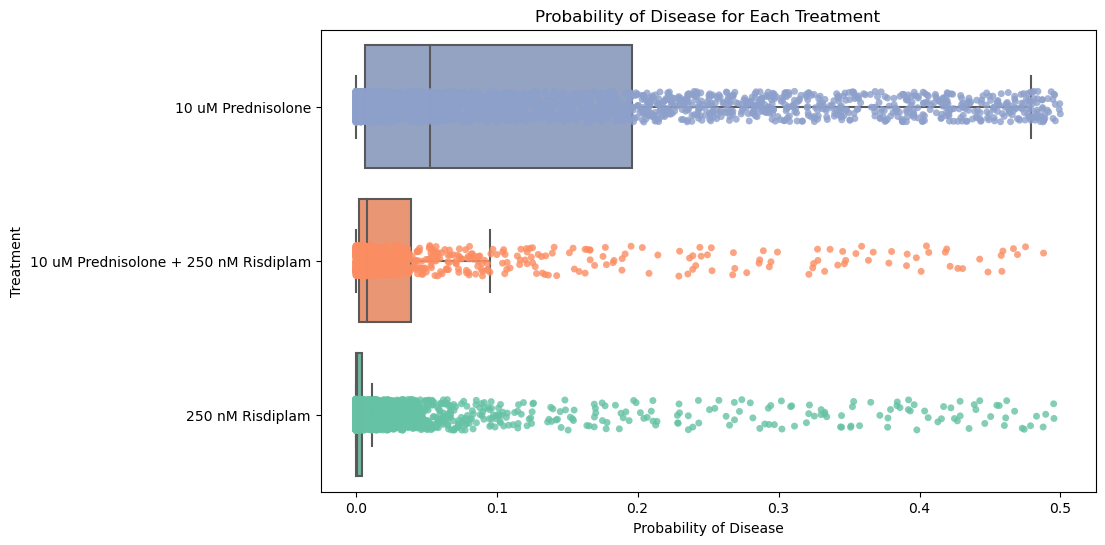

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))


treatment_palette = sns.color_palette('Set2', n_colors=len(df1['Treatment'].unique()))


sns.boxplot(data=df1, x='1 - Probability', y='Treatment', ax=ax, showfliers=False, palette=treatment_palette)


sns.stripplot(data=df1, x='1 - Probability', y='Treatment', palette=treatment_palette, alpha=0.8, marker='o', ax=ax)


ax.set_xlabel('Probability of Disease')
ax.set_ylabel('Treatment')
ax.set_title('Probability of Disease for Each Treatment')


ax.invert_yaxis()


plt.show()


In [26]:
df_valid

class  prediction
0      disease    0.999996
1    wild_type    0.040251
2      disease    0.999938
3      disease    0.998715
4    wild_type    0.010911
..         ...         ...
913  wild_type    0.000013
914    disease    0.999969
915  wild_type    0.000488
916  wild_type    0.000008
917    disease    0.999986

[918 rows x 2 columns]

In [27]:
df1

Common Name  Probability  1 - Probability   
0         r08c06     0.996272         0.003728  \
1         r07c04     0.999698         0.000302   
2         r07c04     0.948614         0.051386   
3         r07c04     0.999768         0.000232   
4         r08c05     0.998770         0.001230   
...          ...          ...              ...   
8686      r07c06     0.996523         0.003477   
8687      r08c07     0.985649         0.014351   
8688      r08c04     0.970807         0.029193   
8689      r07c06     0.999973         0.000027   
8690      r07c09     0.963536         0.036464   

                                  Treatment  
0                          250 nM Risdiplam  
1                          250 nM Risdiplam  
2                          250 nM Risdiplam  
3                          250 nM Risdiplam  
4                          250 nM Risdiplam  
...                                     ...  
8686                       250 nM Risdiplam  
8687                     10 uM Prednisolone  
8688                       250 nM Risdiplam  
8689                       250 nM Risdiplam  
8690  10 uM Prednisolone + 250 nM Risdiplam  

[8691 rows x 4 columns]

In [28]:
df1_copy = df1.copy()

In [29]:
df1_copy = df1[['Treatment', '1 - Probability']].copy()

In [30]:
df1_copy

Treatment  1 - Probability
0                          250 nM Risdiplam         0.003728
1                          250 nM Risdiplam         0.000302
2                          250 nM Risdiplam         0.051386
3                          250 nM Risdiplam         0.000232
4                          250 nM Risdiplam         0.001230
...                                     ...              ...
8686                       250 nM Risdiplam         0.003477
8687                     10 uM Prednisolone         0.014351
8688                       250 nM Risdiplam         0.029193
8689                       250 nM Risdiplam         0.000027
8690  10 uM Prednisolone + 250 nM Risdiplam         0.036464

[8691 rows x 2 columns]

In [31]:
df_valid = df_valid.rename(columns={'class': 'Treatment', 'prediction': '1 - Probability'})
df_valid

Treatment  1 - Probability
0      disease         0.999996
1    wild_type         0.040251
2      disease         0.999938
3      disease         0.998715
4    wild_type         0.010911
..         ...              ...
913  wild_type         0.000013
914    disease         0.999969
915  wild_type         0.000488
916  wild_type         0.000008
917    disease         0.999986

[918 rows x 2 columns]

In [32]:
combined_df = pd.concat([df1_copy, df_valid])
combined_df

Treatment  1 - Probability
0    250 nM Risdiplam         0.003728
1    250 nM Risdiplam         0.000302
2    250 nM Risdiplam         0.051386
3    250 nM Risdiplam         0.000232
4    250 nM Risdiplam         0.001230
..                ...              ...
913         wild_type         0.000013
914           disease         0.999969
915         wild_type         0.000488
916         wild_type         0.000008
917           disease         0.999986

[9609 rows x 2 columns]

In [33]:
unique_treatment_names = combined_df['Treatment'].unique().tolist()
print(unique_treatment_names)


['250 nM Risdiplam', '10 uM Prednisolone + 250 nM Risdiplam', '10 uM Prednisolone', 'disease', 'wild_type']


/tmp/7153087.1.gpu.q/ipykernel_97384/230700001.py:17: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=combined_df, x='1 - Probability', y='Treatment', palette=treatment_palette, alpha=0.8, marker='o', ax=ax)


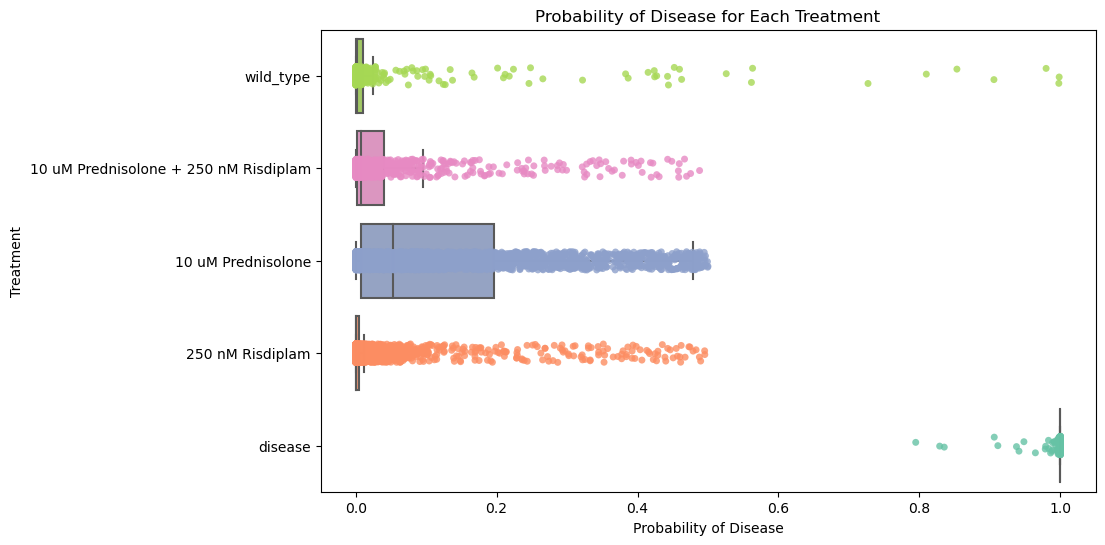

In [34]:
desired_order = ['disease', '250 nM Risdiplam', '10 uM Prednisolone', '10 uM Prednisolone + 250 nM Risdiplam', 'wild_type']
combined_df['Treatment'] = pd.Categorical(combined_df['Treatment'], categories=desired_order, ordered=True)
fig, ax = plt.subplots(figsize=(10, 6))

treatment_palette = sns.color_palette('Set2', n_colors=len(desired_order))


sns.boxplot(data=combined_df, x='1 - Probability', y='Treatment', ax=ax, showfliers=False, palette=treatment_palette)
sns.stripplot(data=combined_df, x='1 - Probability', y='Treatment', palette=treatment_palette, alpha=0.8, marker='o', ax=ax)


ax.set_xlabel('Probability of Disease')
ax.set_ylabel('Treatment')
ax.set_title('Probability of Disease for Each Treatment')


ax.invert_yaxis()
plt.show()

In [ ]:
#Explainable AI: Saliency maps

In [ ]:
from fastai.vision.all import *
from sklearn.metrics import f1_score
import numpy as np
from fastcore import *
from captum.attr import Saliency
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_tensor
import matplotlib.pyplot as plt
from PIL import Image

In [1]:
disease_path = Path('/fast/AG_Metzger/jakob/a728b741-9fed-4bfc-906f-5b828b882892/images/RGB_disease_desmin_disease/')
wild_type_path = Path('/fast/AG_Metzger/jakob/a728b741-9fed-4bfc-906f-5b828b882892/images/RGB_wt_desmin_wild_type/')

def get_label(o):
    if o.parent.name == 'RGB_disease_desmin_disease':
        return 'disease'
    elif o.parent.name == 'RGB_wt_desmin_wild_type':
        return 'wild_type'
    else:
        raise ValueError(f"Unknown label for {o}")



disease_files = get_image_files(disease_path)
wild_type_files = get_image_files(wild_type_path)

num_samples = min(len(disease_files), len(wild_type_files))
disease_files = disease_files[:num_samples]
wild_type_files = wild_type_files[:num_samples]

files = disease_files + wild_type_files
labels = {**{f:disease_path.name for f in disease_files}, **{f:wild_type_path.name for f in wild_type_files}}

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda x: files,
    splitter=RandomSplitter(valid_pct=0.2, seed=123),
    get_y=get_label,
    item_tfms=[Resize(224)],
    batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)]
)
dls = dblock.dataloaders(source=(disease_path, wild_type_path), bs=16, num_workers=4)

num_val_samples = len(dls.valid_ds)
if num_val_samples == 0:
    raise ValueError("Validation set is empty.")


learn = cnn_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(10, cbs=[EarlyStoppingCallback(patience=2)])
print(f'The accuracy of the model is {learn.recorder.values[-1][-1]:.2%}.')

val_indices = range_of(dls.valid)
val_files = [files[i] for i in val_indices]

val_preds = learn.get_preds(dl=dls.valid)


sample_idx = 0  
sample_image = PILImage.create(val_files[sample_idx]).convert('RGB')  


preprocess = learn.dls.after_item
sample = preprocess(sample_image)


input_tensor = to_tensor(sample).unsqueeze(0)
input_tensor = input_tensor.to(learn.dls.device)

saliency = Saliency(learn.model)

/home/mhernan/miniconda3/envs/gpuenv/lib/python3.9/site-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/home/mhernan/miniconda3/envs/gpuenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mhernan/miniconda3/envs/gpuenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


No improvement since epoch 3: early stopping
The accuracy of the model is 96.08%.


/home/mhernan/miniconda3/envs/gpuenv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


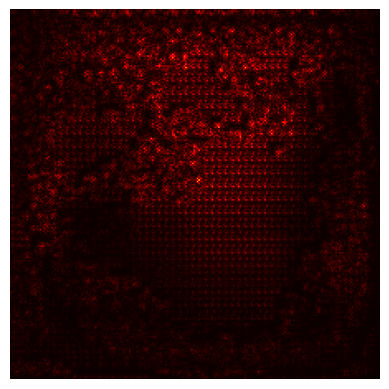

r01c09_r01c09f20p40


In [2]:
sample_idx = 0 
sample_image = PILImage.create(val_files[sample_idx]).convert('RGB')  
preprocess = learn.dls.after_item
sample = preprocess(sample_image)


input_tensor = to_tensor(sample).unsqueeze(0)
input_tensor = input_tensor.to(learn.dls.device)

saliency = Saliency(learn.model)


class_labels = ['disease', 'wild_type'] 


target_index = class_labels.index('disease') 


saliency_map = saliency.attribute(input_tensor, target=target_index)


normalized_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())


gray_map = np.mean(normalized_map.squeeze().cpu().detach().numpy(), axis=0)


plt.imshow(gray_map, cmap='hot', vmin=0, vmax=1)
plt.axis('off')
plt.show()
sample_id = val_files[sample_idx].stem
print(sample_id)

Red Channel Weight: 0.3190
Green Channel Weight: 0.4343
Blue Channel Weight: 0.2466


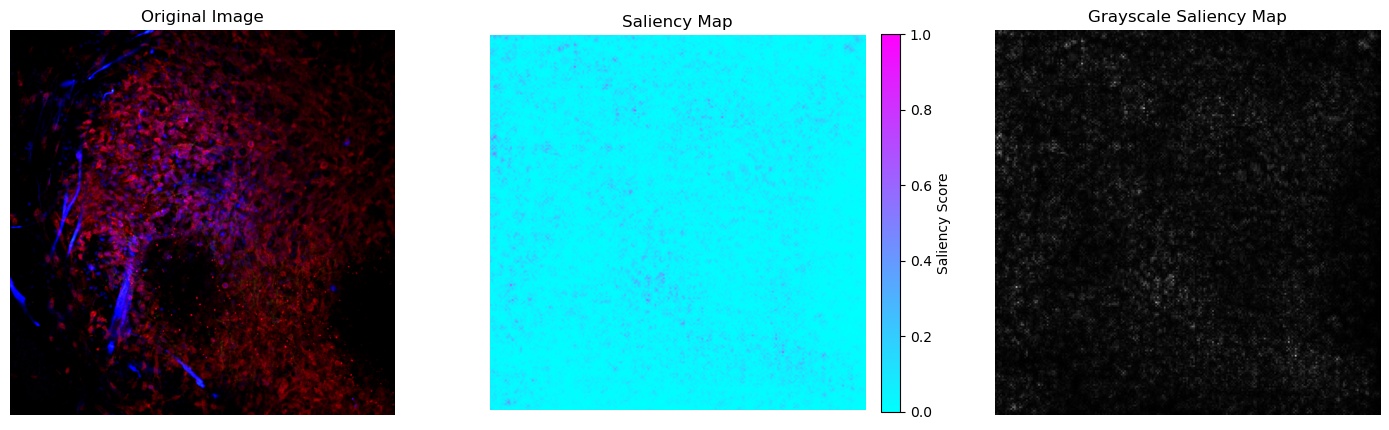

In [58]:
import numpy as np
from PIL import ImageEnhance, ImageOps
import matplotlib.pyplot as plt
from fastai.vision.all import *

file_path = ('/fast/AG_Metzger/jakob/a728b741-9fed-4bfc-906f-5b828b882892/images/RGB_wt_desmin_wild_type/r01c03_r01c03f42p19.tiff')
original_image = PILImage.create(file_path).convert('RGB')


contrast_factor = 11.5 
enhancer = ImageEnhance.Contrast(original_image)
enhanced_image = enhancer.enhance(contrast_factor)


preprocess = learn.dls.after_item
sample = preprocess(enhanced_image)


input_tensor = to_tensor(sample).unsqueeze(0)


input_tensor = input_tensor.to(learn.dls.device)

saliency = Saliency(learn.model)


target_index = class_labels.index('wild_type') 

saliency_map = saliency.attribute(input_tensor, target=target_index)


normalized_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())


red_channel_score = np.mean(normalized_map[:, 0].squeeze().cpu().detach().numpy())
green_channel_score = np.mean(normalized_map[:, 1].squeeze().cpu().detach().numpy())
blue_channel_score = np.mean(normalized_map[:, 2].squeeze().cpu().detach().numpy())


total_saliency_score = red_channel_score + green_channel_score + blue_channel_score


red_channel_weight = red_channel_score / total_saliency_score
green_channel_weight = green_channel_score / total_saliency_score
blue_channel_weight = blue_channel_score / total_saliency_score


print(f"Red Channel Weight: {red_channel_weight:.4f}")
print(f"Green Channel Weight: {green_channel_weight:.4f}")
print(f"Blue Channel Weight: {blue_channel_weight:.4f}")


gray_saliency_map = np.mean(normalized_map.squeeze().cpu().detach().numpy(), axis=0)


resized_saliency_map = ImageOps.fit(PILImage.create(gray_saliency_map), enhanced_image.size)

resized_saliency_map = np.array(resized_saliency_map)


fig, axs = plt.subplots(1, 3, figsize=(18, 5))


axs[0].imshow(enhanced_image)
axs[0].set_title('Original Image')
axs[0].axis('off')


im = axs[1].imshow(resized_saliency_map, cmap='cool', vmin=0, vmax=1)
axs[1].set_title('Saliency Map')
axs[1].axis('off')


cbar = plt.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)
cbar.set_label('Saliency Score')


axs[2].imshow(gray_saliency_map, cmap='gray', vmin=0, vmax=1)
axs[2].set_title('Grayscale Saliency Map')
axs[2].axis('off')

plt.show()


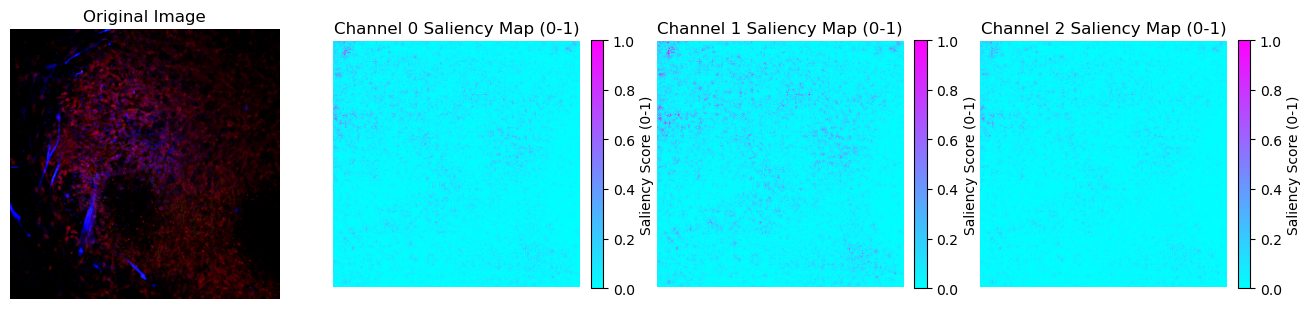

In [59]:
original_image = PILImage.create(file_path).convert('RGB')

contrast_factor = 8.5  
enhancer = ImageEnhance.Contrast(original_image)
enhanced_image = enhancer.enhance(contrast_factor)


preprocess = learn.dls.after_item
sample = preprocess(enhanced_image)


input_tensor = to_tensor(sample).unsqueeze(0)




input_tensor = input_tensor.to(learn.dls.device)

saliency = Saliency(learn.model)


target_index = class_labels.index('wild_type')  


saliency_map = saliency.attribute(input_tensor, target=target_index)


normalized_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())


threshold_mask = normalized_map >= 0.5


fig, axs = plt.subplots(1, 4, figsize=(16, 5)) 


axs[0].imshow(enhanced_image)
axs[0].set_title('Original Image')
axs[0].axis('off')


for channel in range(3):
    axs[channel + 1].imshow(normalized_map.squeeze()[channel].cpu().detach().numpy(), cmap='cool', vmin=0, vmax=1)
    axs[channel + 1].set_title(f'Channel {channel} Saliency Map (0-1)')
    axs[channel + 1].axis('off')


for ax in axs[1:]:
    cbar = plt.colorbar(ax.images[0], ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Saliency Score (0-1)')

plt.show()

/home/mhernan/miniconda3/envs/gpuenv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/mhernan/miniconda3/envs/gpuenv/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


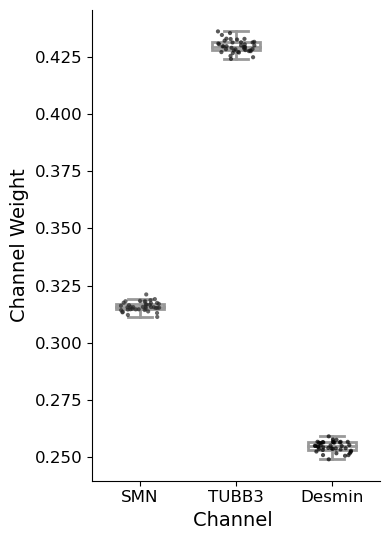

In [8]:
disease_path = Path('/fast/AG_Metzger/jakob/a728b741-9fed-4bfc-906f-5b828b882892/images/RGB_disease_desmin_disease/')
wild_type_path = Path('/fast/AG_Metzger/jakob/a728b741-9fed-4bfc-906f-5b828b882892/images/RGB_wt_desmin_wild_type/')

wild_type_images = [f for f in os.listdir(wild_type_path) if f.endswith('.tiff')][:40] 
disease_images = [f for f in os.listdir(disease_path) if f.endswith('.tiff')][:40]  


saliency = Saliency(learn.model)


red_channel_weights = []
green_channel_weights = []
blue_channel_weights = []


for image_filename in wild_type_images:
 
    file_path = wild_type_path / image_filename
    
   
    original_image = PILImage.create(file_path).convert('RGB')
    contrast_factor = 8.5 
    enhancer = ImageEnhance.Contrast(original_image)
    enhanced_image = enhancer.enhance(contrast_factor)

    
    preprocess = learn.dls.after_item
    sample = preprocess(enhanced_image)

    
    input_tensor = to_tensor(sample).unsqueeze(0)

    
    input_tensor = input_tensor.to(learn.dls.device)

  
    saliency_map = saliency.attribute(input_tensor, target=target_index)

  
    normalized_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())


    red_channel_score = np.mean(normalized_map[:, 0].squeeze().cpu().detach().numpy())
    green_channel_score = np.mean(normalized_map[:, 1].squeeze().cpu().detach().numpy())
    blue_channel_score = np.mean(normalized_map[:, 2].squeeze().cpu().detach().numpy())

  
    total_saliency_score = red_channel_score + green_channel_score + blue_channel_score

    
    red_channel_weight = red_channel_score / total_saliency_score
    green_channel_weight = green_channel_score / total_saliency_score
    blue_channel_weight = blue_channel_score / total_saliency_score

 
    red_channel_weights.append(red_channel_weight)
    green_channel_weights.append(green_channel_weight)
    blue_channel_weights.append(blue_channel_weight)


fig, ax = plt.subplots(figsize=(4, 5.5))


channels = ['SMN', 'TUBB3', 'Desmin']


combined_weights = np.vstack((red_channel_weights, green_channel_weights, blue_channel_weights)).T
weights_df = pd.DataFrame(data=combined_weights, columns=channels)


sns.boxplot(data=weights_df, ax=ax, width=0.5, color='white', fliersize=0, linewidth=2)  
sns.stripplot(data=weights_df, ax=ax, jitter=0.2, size=3, alpha=0.7, color='black')  
ax.tick_params(axis='both', which='both', labelsize=12)
ax.set_ylabel('Channel Weight', fontsize=14)
ax.set_xlabel('Channel ', fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()
